In [1]:
import torch,sklearn

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pathlib
BASE_PATH = pathlib.Path().resolve()
COUNTY_DATA_PATH = BASE_PATH / "drive/MyDrive/CS441/data_merged_encoded.csv"

In [48]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, latent_size, num_layers, hidden_size):
        super(AutoEncoder,self).__init__()

        layers = [layer for _ in range(num_layers) for layer in [torch.nn.Linear(hidden_size, hidden_size), torch.nn.ReLU()]]

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            *layers,
            torch.nn.Linear(hidden_size, latent_size)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_size, hidden_size),
            torch.nn.ReLU(),
            *layers,
            torch.nn.Linear(hidden_size, input_size)
        )

    def forward(self,x):
        latent_space = self.encoder(x)
        x = self.decoder(latent_space)
        return latent_space,x

class DEC(torch.nn.Module):
    def __init__(self, num_clusters, input_size, latent_size, num_layers, hidden_size):
        super(DEC,self).__init__()

        self.encoder = AutoEncoder(input_size, latent_size, num_layers, hidden_size)

        self.centers = torch.nn.Parameter(torch.Tensor(num_clusters, latent_size))
        torch.nn.init.xavier_uniform_(self.centers)

    def soft_assign(self, z):
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.centers)**2, dim=2))
        q = q.pow((1 + 1) / 2)
        return (q.t() / torch.sum(q, dim=1)).t()

    def target_distribution(self, q):
        p = q ** 2 / torch.sum(q, dim=0)
        return (p.t() / torch.sum(p, dim=1)).t()


def train_dec(x, n_clusters=10, latent_dim=16, epochs=50, num_layers=1, hidden_size=128, gamma=0.1, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x_tensor = torch.tensor(x, dtype=torch.float32).to(device)

    idec = DEC(n_clusters, x.shape[1], latent_dim, num_layers, hidden_size).to(device)
    optimizer = torch.optim.Adam(idec.parameters(), lr=lr)

    # Pretrain autoencoder
    for epoch in range(10):
        z, x_recon = idec.encoder(x_tensor)
        loss = torch.nn.functional.mse_loss(x_recon, x_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # K-Means init
    with torch.no_grad():
        z, _ = idec.encoder(x_tensor)
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init=20).fit(z.cpu().numpy())
    idec.centers.data = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

    for epoch in range(epochs):
        z, x_recon = idec.encoder(x_tensor)
        q = idec.soft_assign(z)
        p = idec.target_distribution(q)

        # KL divergence loss (DEC)
        kl_loss = torch.nn.functional.kl_div(q.log(), p, reduction='batchmean')
        # Reconstruction loss (autoencoder)
        recon_loss = torch.nn.functional.mse_loss(x_recon, x_tensor)
        # Total IDEC loss
        loss = recon_loss + gamma * kl_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"[Epoch {epoch}] Total Loss: {loss.item():.4f} | Recon: {recon_loss.item():.4f} | KL: {kl_loss.item():.4f}")

    return idec, z.detach().cpu().numpy(), torch.argmax(q, dim=1).cpu().numpy()



In [5]:
import pandas as pd

pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 100)

df = pd.read_csv(COUNTY_DATA_PATH).iloc[:,:17]
df.drop(columns=['Percent of adults who are not high school graduates, 2019-23', 'Percent of adults who are high school graduates (or equivalent), 2019-23', 'Percent of adults completing some college or associate degree, 2019-23', "Percent of adults with a bachelor's degree or higher, 2019-23"], inplace=True)
df.head()

print(df.dtypes)

FIPS                           int64
2024 Urban Influence Code    float64
Economic_typology_2015       float64
NATURAL_CHG_2023             float64
DOMESTIC_MIG_2023            float64
R_BIRTH_2023                 float64
R_NATURAL_CHG_2023           float64
R_INTERNATIONAL_MIG_2023     float64
R_DOMESTIC_MIG_2023          float64
MEDHHINC_2023                float64
PCTPOVALL_2023               float64
Employed_2023                float64
Unemployment_rate_2023       float64
dtype: object


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv(COUNTY_DATA_PATH).iloc[:,:17]
df.drop(columns=['Percent of adults who are not high school graduates, 2019-23', 'Percent of adults who are high school graduates (or equivalent), 2019-23', 'Percent of adults completing some college or associate degree, 2019-23', "Percent of adults with a bachelor's degree or higher, 2019-23"], inplace=True)
df.head()

scaler = StandardScaler()
df = scaler.fit_transform(df)

train, test = train_test_split(df, test_size=0.2, random_state=42)

#model, embed, label = train_dec(train, n_clusters=6, latent_dim=6, num_layers=1, hidden_size=25, epochs=10000, gamma=0.1, lr=1e-4)

In [113]:
import numpy as np

np.unique(label)


array([0, 1, 2, 4])

In [114]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

sil_score = silhouette_score(train, label)
db_score = davies_bouldin_score(train, label)
ch_score = calinski_harabasz_score(train, label)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

Silhouette Score: -0.057
Davies-Bouldin Index: 2.910
Calinski-Harabasz Index: 34.766


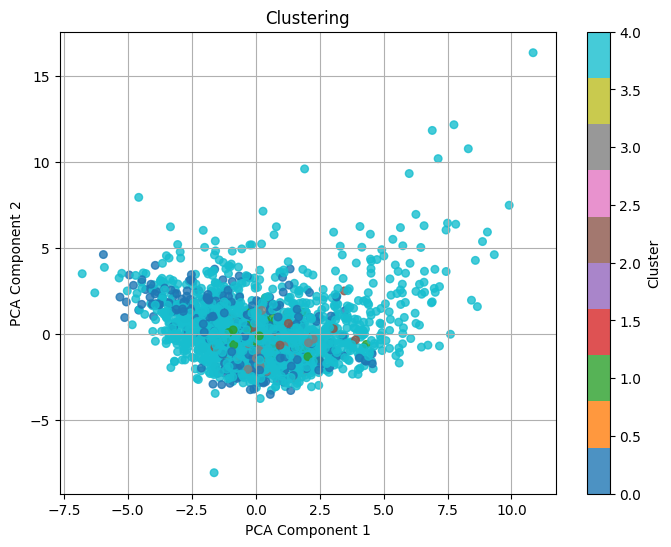

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(train)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label, cmap='tab10', s=30, alpha=0.8)
plt.title("Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()

In [7]:
!pip install ray[tune]
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 34.0 MB/s eta 0:00:00


In [8]:
from ray import tune
import ray
import plotly.graph_objects as go
import numpy as np

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


res = {'sil_score': [], 'db_score': [], 'ch_score': []}

def objective(config):

    for i in range(10):
      model, embed, label = train_dec(train, n_clusters=config["n_clusters"], latent_dim=config["latent_dim"], hidden_size=config['hidden_size'], num_layers=config["num_layers"], epochs=2000, gamma=config["gamma"], lr=1e-4)
      sil_score = silhouette_score(train, label)
      db_score = davies_bouldin_score(train, label)
      ch_score = calinski_harabasz_score(train, label)
      res['sil_score'].append(sil_score)
      res['db_score'].append(db_score)
      res['ch_score'].append(ch_score)

    # sil_score = silhouette_score(train, label)
    # db_score = davies_bouldin_score(train, label)
    # ch_score = calinski_harabasz_score(train, label)
    # res['sil_score'].append(sil_score)
    # res['db_score'].append(db_score)
    # res['ch_score'].append(ch_score)

    return {'sil_score': np.mean(res['sil_score']), 'db_score': np.mean(res['db_score']), 'ch_score': np.mean(res['ch_score'])}


search_space = {
    "n_clusters": tune.grid_search([4,5,6,7,8]),
    "latent_dim": tune.grid_search([8,16,32]),
    "num_layers": tune.grid_search([1,2,3,4]),
    "hidden_size": tune.grid_search([32,64,128,256]),
    "gamma": tune.grid_search([0.1,1,2])
}

objective = tune.with_resources(objective, {'cpu': 0.25, 'gpu': 1/48})

tuner = tune.Tuner(objective, tune_config=tune.TuneConfig(num_samples=1, mode='min'), param_space=search_space)

results = tuner.fit()



2025-04-12 16:02:26,464	INFO worker.py:1852 -- Started a local Ray instance.
2025-04-12 16:02:27,481	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+------------------------------------------------------------------+
| Configuration for experiment     objective_2025-04-12_16-02-24   |
+------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator           |
| Scheduler                        FIFOScheduler                   |
| Number of trials                 720                             |
+------------------------------------------------------------------+

View detailed results here: /root/ray_results/objective_2025-04-12_16-02-24
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts`

Trial status: 200 PENDING
Current time: 2025-04-12 16:02:30. Total running time: 2s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------

2025-04-12 16:04:20,748	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00026
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00026 errored after 0 iterations at 2025-04-12 16:04:20. Total running time: 1min 52s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00026_26_gamma=2,hidden_size=32,latent_dim=32,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt
(raylet) WARNING: 86 PYTHON worker processes have been started on node: 752cbe8e69e5d9742be08f7e87b2c68ce6c5219641222fb3a69caee4 with address: 172.28.0.12. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
(objective pid=5898) [Epoch 0] Total Loss: 0.9654 | Recon: 0.9651 | KL: 0.0028 [repeated 630x across cluster]


2025-04-12 16:04:26,091	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00034
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00034 errored after 0 iterations at 2025-04-12 16:04:26. Total running time: 1min 58s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00034_34_gamma=1,hidden_size=256,latent_dim=32,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt


2025-04-12 16:04:26,325	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00015
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00015 errored after 0 iterations at 2025-04-12 16:04:26. Total running time: 1min 58s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00015_15_gamma=0.1000,hidden_size=64,latent_dim=16,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt
(objective pid=5898) [Epoch 160] Total Loss: 0.9220 | Recon: 0.9211 | KL: 0.0086 [repeated 614x across cluster]

Trial status: 45 RUNNING | 3 ERROR | 200 PENDING
Current time: 2025-04-12 16:04:30. Total running time: 2min 2s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+---------------------------------------------------------------------------------------------------------+
| Trial name              status       n_clusters     latent_dim     num_layers     hidden_size     gamma |
+--------------------------------------------------------------------------------------------

2025-04-12 16:05:24,589	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00001
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00001 errored after 0 iterations at 2025-04-12 16:05:24. Total running time: 2min 56s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00001_1_gamma=1,hidden_size=32,latent_dim=8,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt
(objective pid=7451) 
(objective pid=5901) [Epoch 30] Total Loss: 0.9655 | Recon: 0.9609 | KL: 0.0023 [repeated 656x across cluster]

Trial status: 47 RUNNING | 4 ERROR | 200 PENDING
Current time: 2025-04-12 16:05:30. Total running time: 3min 2s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+---------------------------------------------------------------------------------------------------------+
| Trial name              status       n_clusters     latent_dim     num_layers     hidden_size     gamma |
+------------------------------------------------------------------------------

2025-04-12 16:05:42,806	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00031
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00031 errored after 0 iterations at 2025-04-12 16:05:42. Total running time: 3min 15s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00031_31_gamma=1,hidden_size=128,latent_dim=32,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt
(objective pid=5907) [Epoch 1900] Total Loss: 0.0212 | Recon: 0.0211 | KL: 0.0006 [repeated 632x across cluster]
(objective pid=5900) [Epoch 200] Total Loss: 0.7199 | Recon: 0.7195 | KL: 0.0033 [repeated 643x across cluster]

Trial objective_87e6e_00051 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00051 config         |
+--------------------------------------------+
| gamma                                  0.1 |
| hidden_size                             64 |
| latent_dim                              16 |
| n_clusters                               5 |
| num_layers           

2025-04-12 16:05:58,525	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00035
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00035 errored after 0 iterations at 2025-04-12 16:05:58. Total running time: 3min 30s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00035_35_gamma=2,hidden_size=256,latent_dim=32,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt

Trial status: 46 RUNNING | 6 ERROR | 200 PENDING
Current time: 2025-04-12 16:06:00. Total running time: 3min 32s
Logical resource usage: 11.75/12 CPUs, 0.9791666666666673/1 GPUs (0.0/1.0 accelerator_type:A100)
+---------------------------------------------------------------------------------------------------------+
| Trial name              status       n_clusters     latent_dim     num_layers     hidden_size     gamma |
+---------------------------------------------------------------------------------------------------------+
| objective_87e6e_00000   RUNNING               4              8              1              32    

2025-04-12 16:08:53,396	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00038
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00038 errored after 0 iterations at 2025-04-12 16:08:53. Total running time: 6min 25s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00038_38_gamma=2,hidden_size=32,latent_dim=8,n_clusters=5,num_layers=1_2025-04-12_16-02-28/error.txt
(objective pid=5901) [Epoch 500] Total Loss: 0.6083 | Recon: 0.6076 | KL: 0.0004 [repeated 648x across cluster]
(objective pid=5908) 
(objective pid=6461) 
(objective pid=5905) [Epoch 1810] Total Loss: 0.0484 | Recon: 0.0481 | KL: 0.0003 [repeated 651x across cluster]

Trial status: 47 RUNNING | 7 ERROR | 200 PENDING
Current time: 2025-04-12 16:09:01. Total running time: 6min 33s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+---------------------------------------------------------------------------------------------------------+
| Trial name              status       n_clusters

2025-04-12 16:09:49,562	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00024
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00024 errored after 0 iterations at 2025-04-12 16:09:49. Total running time: 7min 21s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00024_24_gamma=0.1000,hidden_size=32,latent_dim=32,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt
(objective pid=7615) 
(objective pid=6830) [Epoch 1760] Total Loss: 0.0714 | Recon: 0.0714 | KL: 0.0000 [repeated 647x across cluster]
(objective pid=6931) 
(objective pid=5900) [Epoch 880] Total Loss: 0.1384 | Recon: 0.1382 | KL: 0.0021 [repeated 614x across cluster]
(objective pid=9930) 
(objective pid=5901) [Epoch 330] Total Loss: 0.7629 | Recon: 0.7570 | KL: 0.0029 [repeated 642x across cluster]

Trial status: 47 RUNNING | 8 ERROR | 200 PENDING
Current time: 2025-04-12 16:10:01. Total running time: 7min 33s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------

2025-04-12 16:10:20,128	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00018
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00018 errored after 0 iterations at 2025-04-12 16:10:20. Total running time: 7min 52s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00018_18_gamma=0.1000,hidden_size=128,latent_dim=16,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt
(objective pid=5900) [Epoch 1610] Total Loss: 0.0494 | Recon: 0.0493 | KL: 0.0012 [repeated 638x across cluster]
(objective pid=5905) [Epoch 110] Total Loss: 0.9267 | Recon: 0.9256 | KL: 0.0011 [repeated 649x across cluster]
(objective pid=5898) [Epoch 850] Total Loss: 0.3967 | Recon: 0.3963 | KL: 0.0046 [repeated 636x across cluster]

Trial status: 47 RUNNING | 9 ERROR | 200 PENDING
Current time: 2025-04-12 16:10:31. Total running time: 8min 3s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------

2025-04-12 16:11:37,265	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00033
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00033 errored after 0 iterations at 2025-04-12 16:11:37. Total running time: 9min 9s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00033_33_gamma=0.1000,hidden_size=256,latent_dim=32,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt
(objective pid=5904) 


2025-04-12 16:11:39,911	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00030
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00030 errored after 0 iterations at 2025-04-12 16:11:39. Total running time: 9min 12s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00030_30_gamma=0.1000,hidden_size=128,latent_dim=32,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt
(objective pid=5905) [Epoch 320] Total Loss: 0.4915 | Recon: 0.4900 | KL: 0.0016 [repeated 621x across cluster]
(objective pid=5904) 
(objective pid=5902) 
(objective pid=5901) [Epoch 1510] Total Loss: 0.2173 | Recon: 0.2168 | KL: 0.0002 [repeated 634x across cluster]
(objective pid=9930) 
(objective pid=5901) [Epoch 1680] Total Loss: 0.1840 | Recon: 0.1837 | KL: 0.0002 [repeated 665x across cluster]
(objective pid=5907) 
(objective pid=6082) [Epoch 1020] Total Loss: 0.3020 | Recon: 0.3018 | KL: 0.0001 [repeated 643x across cluster]

Trial status: 46 RUNNING | 11 ERROR | 200 PENDING
Current time: 2025-04-12 16:12:01. Tota

2025-04-12 16:12:33,324	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00022
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00022 errored after 0 iterations at 2025-04-12 16:12:33. Total running time: 10min 5s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00022_22_gamma=1,hidden_size=256,latent_dim=16,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt
(objective pid=5901) [Epoch 1270] Total Loss: 0.3014 | Recon: 0.3001 | KL: 0.0007 [repeated 655x across cluster]
(objective pid=5898) [Epoch 570] Total Loss: 0.5653 | Recon: 0.5653 | KL: 0.0003 [repeated 614x across cluster]
(objective pid=5900) [Epoch 1720] Total Loss: 0.0439 | Recon: 0.0439 | KL: 0.0003 [repeated 644x across cluster]
(objective pid=5901) [Epoch 1800] Total Loss: 0.1844 | Recon: 0.1837 | KL: 0.0003 [repeated 657x across cluster]


2025-04-12 16:12:56,325	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00029
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00029 errored after 0 iterations at 2025-04-12 16:12:56. Total running time: 10min 28s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00029_29_gamma=2,hidden_size=64,latent_dim=32,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt
(objective pid=5898) [Epoch 1050] Total Loss: 0.3826 | Recon: 0.3826 | KL: 0.0001 [repeated 656x across cluster]


2025-04-12 16:12:58,372	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00019
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00019 errored after 0 iterations at 2025-04-12 16:12:58. Total running time: 10min 30s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00019_19_gamma=1,hidden_size=128,latent_dim=16,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt

Trial objective_87e6e_00059 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00059 config         |
+--------------------------------------------+
| gamma                                    2 |
| hidden_size                            256 |
| latent_dim                              16 |
| n_clusters                               5 |
| num_layers                               1 |
+--------------------------------------------+

Trial status: 46 RUNNING | 14 ERROR | 200 PENDING
Current time: 2025-04-12 16:13:01. Total running time: 10min 33s
Logical resource usage: 12.0/12 CPUs,

2025-04-12 16:14:04,491	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00027
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00027 errored after 0 iterations at 2025-04-12 16:14:04. Total running time: 11min 36s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00027_27_gamma=0.1000,hidden_size=64,latent_dim=32,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt

Trial objective_87e6e_00002 completed after 1 iterations at 2025-04-12 16:14:08. Total running time: 11min 40s
+-------------------------------------------------+
| Trial objective_87e6e_00002 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        676.121 |
| time_total_s                            676.121 |
| training_iteration                            1 |
| ch_score                                75.5302 |
| db_score                                3.27902 |
| sil_score                              -0.04886

2025-04-12 16:14:15,678	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00050
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00050 errored after 0 iterations at 2025-04-12 16:14:15. Total running time: 11min 47s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00050_50_gamma=2,hidden_size=32,latent_dim=16,n_clusters=5,num_layers=1_2025-04-12_16-02-28/error.txt
(objective pid=5903) [Epoch 520] Total Loss: 0.0359 | Recon: 0.0349 | KL: 0.0010 [repeated 636x across cluster]
(objective pid=12517) 
(objective pid=5904) [Epoch 660] Total Loss: 0.0276 | Recon: 0.0271 | KL: 0.0003 [repeated 630x across cluster]

Trial objective_87e6e_00037 completed after 1 iterations at 2025-04-12 16:14:26. Total running time: 11min 59s
+-------------------------------------------------+
| Trial objective_87e6e_00037 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        689.034 |
| time_total_s 

2025-04-12 16:15:03,290	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00058
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00058 errored after 0 iterations at 2025-04-12 16:15:03. Total running time: 12min 35s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00058_58_gamma=1,hidden_size=256,latent_dim=16,n_clusters=5,num_layers=1_2025-04-12_16-02-28/error.txt
(objective pid=5907) [Epoch 1280] Total Loss: 0.0302 | Recon: 0.0301 | KL: 0.0011 [repeated 613x across cluster]

Trial objective_87e6e_00039 completed after 1 iterations at 2025-04-12 16:15:04. Total running time: 12min 36s
+-------------------------------------------------+
| Trial objective_87e6e_00039 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        725.841 |
| time_total_s                            725.841 |
| training_iteration                            1 |
| ch_score                                62

2025-04-12 16:15:43,428	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00028
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00028 errored after 0 iterations at 2025-04-12 16:15:43. Total running time: 13min 15s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00028_28_gamma=1,hidden_size=64,latent_dim=32,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt
(objective pid=5903) [Epoch 870] Total Loss: 0.0276 | Recon: 0.0269 | KL: 0.0007 [repeated 480x across cluster]

Trial objective_87e6e_00073 started with configuration:
+-------------------------------------------+
| Trial objective_87e6e_00073 config        |
+-------------------------------------------+
| gamma                                   1 |
| hidden_size                            32 |
| latent_dim                              8 |
| n_clusters                              6 |
| num_layers                              1 |
+-------------------------------------------+

Trial objective_87e6e_00075 started with configura

2025-04-12 16:16:15,028	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00021
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line

(objective pid=12517) 

Trial objective_87e6e_00021 errored after 0 iterations at 2025-04-12 16:16:15. Total running time: 13min 47s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00021_21_gamma=0.1000,hidden_size=256,latent_dim=16,n_clusters=4,num_layers=1_2025-04-12_16-02-28/error.txt


2025-04-12 16:16:15,417	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00067
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00067 errored after 0 iterations at 2025-04-12 16:16:15. Total running time: 13min 47s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00067_67_gamma=1,hidden_size=128,latent_dim=32,n_clusters=5,num_layers=1_2025-04-12_16-02-29/error.txt

Trial objective_87e6e_00010 completed after 1 iterations at 2025-04-12 16:16:15. Total running time: 13min 47s
+------------------------------------------------+
| Trial objective_87e6e_00010 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       796.973 |
| time_total_s                           796.973 |
| training_iteration                           1 |
| ch_score                               118.403 |
| db_score                               2.50714 |
| sil_score                              0.03361 |
+----------

2025-04-12 16:16:18,344	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00068
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00068 errored after 0 iterations at 2025-04-12 16:16:18. Total running time: 13min 50s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00068_68_gamma=2,hidden_size=128,latent_dim=32,n_clusters=5,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=7543) [Epoch 1690] Total Loss: 0.0011 | Recon: 0.0010 | KL: 0.0000 [repeated 514x across cluster]
(objective pid=7615) 
(objective pid=9190) 

Trial objective_87e6e_00009 completed after 1 iterations at 2025-04-12 16:16:23. Total running time: 13min 55s
+------------------------------------------------+
| Trial objective_87e6e_00009 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       803.544 |
| time_total_s                           803.544 |
| training_iteration                           1 |
| ch_sc

2025-04-12 16:16:43,794	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00071
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00071 errored after 0 iterations at 2025-04-12 16:16:43. Total running time: 14min 15s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00071_71_gamma=2,hidden_size=256,latent_dim=32,n_clusters=5,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=9764) [Epoch 1380] Total Loss: 0.0393 | Recon: 0.0392 | KL: 0.0007 [repeated 568x across cluster]

Trial objective_87e6e_00094 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00094 config         |
+--------------------------------------------+
| gamma                                    1 |
| hidden_size                            256 |
| latent_dim                              16 |
| n_clusters                               6 |
| num_layers                               1 |
+--------------------------------------------+

Trial objective_87e6e_00046 completed a

2025-04-12 16:17:05,531	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00084
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00084 errored after 0 iterations at 2025-04-12 16:17:05. Total running time: 14min 37s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00084_84_gamma=0.1000,hidden_size=32,latent_dim=16,n_clusters=6,num_layers=1_2025-04-12_16-02-29/error.txt

Trial objective_87e6e_00100 started with configuration:
+-------------------------------------------+
| Trial objective_87e6e_00100 config        |
+-------------------------------------------+
| gamma                                   1 |
| hidden_size                            64 |
| latent_dim                             32 |
| n_clusters                              6 |
| num_layers                              1 |
+-------------------------------------------+

Trial objective_87e6e_00098 started with configuration:
+-------------------------------------------+
| Trial objective_87e6e_00098 config        |
+--------

2025-04-12 16:20:38,514	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00103
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00103 errored after 0 iterations at 2025-04-12 16:20:38. Total running time: 18min 10s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00103_103_gamma=1,hidden_size=128,latent_dim=32,n_clusters=6,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=15414) 
(objective pid=11937) [Epoch 1480] Total Loss: 0.0012 | Recon: 0.0012 | KL: 0.0001 [repeated 637x across cluster]
(objective pid=12968) 
(objective pid=17249) [Epoch 1260] Total Loss: 0.0053 | Recon: 0.0053 | KL: 0.0004 [repeated 623x across cluster]
(objective pid=13381) 
(objective pid=10943) [Epoch 1040] Total Loss: 0.0125 | Recon: 0.0125 | KL: 0.0001 [repeated 637x across cluster]
(objective pid=14083) [Epoch 760] Total Loss: 0.4483 | Recon: 0.4437 | KL: 0.0046 [repeated 645x across cluster]

Trial status: 36 TERMINATED | 24 ERROR | 47 RUNNING | 200 PENDING
Current time: 2025-04-12 16:21:02. Total 

2025-04-12 16:22:18,987	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00070
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00070 errored after 0 iterations at 2025-04-12 16:22:18. Total running time: 19min 51s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00070_70_gamma=1,hidden_size=256,latent_dim=32,n_clusters=5,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=12515) 
(objective pid=11503) [Epoch 1560] Total Loss: 0.0044 | Recon: 0.0043 | KL: 0.0001 [repeated 625x across cluster]
(objective pid=11937) [Epoch 100] Total Loss: 0.3635 | Recon: 0.3625 | KL: 0.0102 [repeated 620x across cluster]
(objective pid=15725) 
(objective pid=16910) 

Trial status: 37 TERMINATED | 25 ERROR | 47 RUNNING | 200 PENDING
Current time: 2025-04-12 16:22:32. Total running time: 20min 4s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------

2025-04-12 16:22:35,027	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00072
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00072 errored after 0 iterations at 2025-04-12 16:22:35. Total running time: 20min 7s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00072_72_gamma=0.1000,hidden_size=32,latent_dim=8,n_clusters=6,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=11278) [Epoch 1840] Total Loss: 0.0037 | Recon: 0.0035 | KL: 0.0001 [repeated 599x across cluster]

Trial objective_87e6e_00056 completed after 1 iterations at 2025-04-12 16:22:39. Total running time: 20min 11s
+-------------------------------------------------+
| Trial objective_87e6e_00056 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        715.195 |
| time_total_s                            715.195 |
| training_iteration                            1 |
| ch_score                               

2025-04-12 16:25:12,680	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00106
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00106 errored after 0 iterations at 2025-04-12 16:25:12. Total running time: 22min 44s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00106_106_gamma=1,hidden_size=256,latent_dim=32,n_clusters=6,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=19473) 
(objective pid=13381) [Epoch 930] Total Loss: 0.0576 | Recon: 0.0574 | KL: 0.0001 [repeated 625x across cluster]
(objective pid=12968) 

Trial objective_87e6e_00060 completed after 1 iterations at 2025-04-12 16:25:17. Total running time: 22min 49s
+-------------------------------------------------+
| Trial objective_87e6e_00060 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        703.987 |
| time_total_s                            703.987 |
| training_iteration                            1

2025-04-12 16:27:04,741	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00064
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00064 errored after 0 iterations at 2025-04-12 16:27:04. Total running time: 24min 36s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00064_64_gamma=1,hidden_size=64,latent_dim=32,n_clusters=5,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=13837) [Epoch 1270] Total Loss: 0.0013 | Recon: 0.0012 | KL: 0.0004 [repeated 631x across cluster]
(objective pid=17914) 
(objective pid=19473) 
(objective pid=14975) [Epoch 250] Total Loss: 0.3286 | Recon: 0.3162 | KL: 0.0062 [repeated 574x across cluster]
(objective pid=14408) [Epoch 1850] Total Loss: 0.1541 | Recon: 0.1535 | KL: 0.0003 [repeated 615x across cluster]

Trial objective_87e6e_00074 completed after 1 iterations at 2025-04-12 16:27:20. Total running time: 24min 53s
+-------------------------------------------------+
| Trial objective_87e6e_00074 result              |
+------------------------------

2025-04-12 16:28:49,048	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00090
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line

(objective pid=17914) 

Trial objective_87e6e_00090 errored after 0 iterations at 2025-04-12 16:28:49. Total running time: 26min 21s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00090_90_gamma=0.1000,hidden_size=128,latent_dim=16,n_clusters=6,num_layers=1_2025-04-12_16-02-29/error.txt

Trial objective_87e6e_00069 completed after 1 iterations at 2025-04-12 16:28:49. Total running time: 26min 21s
+-------------------------------------------------+
| Trial objective_87e6e_00069 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        798.191 |
| time_total_s                            798.191 |
| training_iteration                            1 |
| ch_score                                16.3682 |
| db_score                                5.17462 |
| sil_score              

2025-04-12 16:31:39,918	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00132
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00132 errored after 0 iterations at 2025-04-12 16:31:39. Total running time: 29min 12s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00132_132_gamma=0.1000,hidden_size=32,latent_dim=32,n_clusters=7,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=21289) 
(objective pid=23225) 
(objective pid=19154) [Epoch 370] Total Loss: 0.7312 | Recon: 0.7309 | KL: 0.0036 [repeated 614x across cluster]
(objective pid=21650) 

Trial objective_87e6e_00153 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00153 config         |
+--------------------------------------------+
| gamma                                  0.1 |
| hidden_size                            256 |
| latent_dim                               8 |
| n_clusters                               8 |
| num_layers                               1 |
+------------

2025-04-12 16:32:37,838	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00129
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00129 errored after 0 iterations at 2025-04-12 16:32:37. Total running time: 30min 10s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00129_129_gamma=0.1000,hidden_size=256,latent_dim=16,n_clusters=7,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=18855) [Epoch 530] Total Loss: 0.0050 | Recon: 0.0048 | KL: 0.0001 [repeated 605x across cluster]
(objective pid=20665) 
(objective pid=19154) [Epoch 210] Total Loss: 0.9171 | Recon: 0.9169 | KL: 0.0020 [repeated 600x across cluster]
(objective pid=26183) [Epoch 480] Total Loss: 0.0346 | Recon: 0.0330 | KL: 0.0016 [repeated 642x across cluster]
(objective pid=19473) [Epoch 910] Total Loss: 0.3632 | Recon: 0.3632 | KL: 0.0000 [repeated 640x across cluster]
(objective pid=24305) 

Trial objective_87e6e_00156 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_0

2025-04-12 16:33:43,334	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00107
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00107 errored after 0 iterations at 2025-04-12 16:33:43. Total running time: 31min 15s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00107_107_gamma=2,hidden_size=256,latent_dim=32,n_clusters=6,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=19473) [Epoch 210] Total Loss: 0.9311 | Recon: 0.9286 | KL: 0.0025 [repeated 618x across cluster]
(objective pid=22996) 
(objective pid=21650) 
(objective pid=20516) [Epoch 1980] Total Loss: 0.0408 | Recon: 0.0404 | KL: 0.0002 [repeated 616x across cluster]


2025-04-12 16:33:52,251	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00142
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00142 errored after 0 iterations at 2025-04-12 16:33:52. Total running time: 31min 24s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00142_142_gamma=1,hidden_size=256,latent_dim=32,n_clusters=7,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=21784) 
(objective pid=25639) 
(objective pid=24318) [Epoch 1740] Total Loss: 0.0010 | Recon: 0.0009 | KL: 0.0000 [repeated 623x across cluster]
(objective pid=19473) [Epoch 630] Total Loss: 0.4925 | Recon: 0.4851 | KL: 0.0075 [repeated 623x across cluster]
(objective pid=22040) 

Trial status: 79 TERMINATED | 33 ERROR | 45 RUNNING | 200 PENDING
Current time: 2025-04-12 16:34:03. Total running time: 31min 36s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------------

2025-04-12 16:34:45,535	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00110
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00110 errored after 0 iterations at 2025-04-12 16:34:45. Total running time: 32min 17s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00110_110_gamma=2,hidden_size=32,latent_dim=8,n_clusters=7,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=24519) [Epoch 1480] Total Loss: 0.2444 | Recon: 0.2444 | KL: 0.0004 [repeated 607x across cluster]

Trial objective_87e6e_00109 completed after 1 iterations at 2025-04-12 16:34:47. Total running time: 32min 19s
+------------------------------------------------+
| Trial objective_87e6e_00109 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       714.368 |
| time_total_s                           714.368 |
| training_iteration                           1 |
| ch_score                               56.2353 |


2025-04-12 16:37:58,833	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00131
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00131 errored after 0 iterations at 2025-04-12 16:37:58. Total running time: 35min 31s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00131_131_gamma=2,hidden_size=256,latent_dim=16,n_clusters=7,num_layers=1_2025-04-12_16-02-29/error.txt

Trial objective_87e6e_00164 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00164 config         |
+--------------------------------------------+
| gamma                                    2 |
| hidden_size                            128 |
| latent_dim                              16 |
| n_clusters                               8 |
| num_layers                               1 |
+--------------------------------------------+
(objective pid=27673) 
(objective pid=21422) [Epoch 240] Total Loss: 0.1012 | Recon: 0.0998 | KL: 0.0014 [repeated 602x across cluster]

Trial objective

2025-04-12 16:40:46,731	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00143
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00143 errored after 0 iterations at 2025-04-12 16:40:46. Total running time: 38min 18s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00143_143_gamma=2,hidden_size=256,latent_dim=32,n_clusters=7,num_layers=1_2025-04-12_16-02-29/error.txt

Trial objective_87e6e_00133 completed after 1 iterations at 2025-04-12 16:40:48. Total running time: 38min 20s
+-------------------------------------------------+
| Trial objective_87e6e_00133 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                         717.23 |
| time_total_s                             717.23 |
| training_iteration                            1 |
| ch_score                                39.3467 |
| db_score                                 3.0479 |
| sil_score                              -0.17588 |


2025-04-12 16:43:12,899	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00159
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00159 errored after 0 iterations at 2025-04-12 16:43:12. Total running time: 40min 45s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00159_159_gamma=0.1000,hidden_size=64,latent_dim=16,n_clusters=8,num_layers=1_2025-04-12_16-02-29/error.txt

Trial objective_87e6e_00151 completed after 1 iterations at 2025-04-12 16:43:15. Total running time: 40min 47s
+-------------------------------------------------+
| Trial objective_87e6e_00151 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        753.927 |
| time_total_s                            753.927 |
| training_iteration                            1 |
| ch_score                                 55.122 |
| db_score                                2.72215 |
| sil_score                              -0.1336

2025-04-12 16:44:38,130	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00192
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00192 errored after 0 iterations at 2025-04-12 16:44:38. Total running time: 42min 10s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00192_192_gamma=0.1000,hidden_size=32,latent_dim=16,n_clusters=4,num_layers=2_2025-04-12_16-02-29/error.txt
(objective pid=26002) [Epoch 1040] Total Loss: 0.0203 | Recon: 0.0199 | KL: 0.0038 [repeated 599x across cluster]
(objective pid=26002) [Epoch 1170] Total Loss: 0.0189 | Recon: 0.0185 | KL: 0.0034 [repeated 583x across cluster]
(objective pid=27673) [Epoch 1130] Total Loss: 0.0510 | Recon: 0.0508 | KL: 0.0001 [repeated 565x across cluster]
(objective pid=33037) 
(objective pid=27673) 

Trial objective_87e6e_00156 completed after 1 iterations at 2025-04-12 16:44:54. Total running time: 42min 26s
+-------------------------------------------------+
| Trial objective_87e6e_00156 result              |
+-----------------------

2025-04-12 16:46:16,341	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00162
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line

(objective pid=33476) 

Trial objective_87e6e_00162 errored after 0 iterations at 2025-04-12 16:46:16. Total running time: 43min 48s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00162_162_gamma=0.1000,hidden_size=128,latent_dim=16,n_clusters=8,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=27673) [Epoch 1420] Total Loss: 0.0381 | Recon: 0.0376 | KL: 0.0002 [repeated 549x across cluster]
(objective pid=29940) 

Trial objective_87e6e_00157 completed after 1 iterations at 2025-04-12 16:46:21. Total running time: 43min 53s
+-------------------------------------------------+
| Trial objective_87e6e_00157 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        729.263 |
| time_total_s                            729.263 |
| training_iteration                       

2025-04-12 16:47:26,781	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00204
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00204 errored after 0 iterations at 2025-04-12 16:47:26. Total running time: 44min 58s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00204_204_gamma=0.1000,hidden_size=32,latent_dim=32,n_clusters=4,num_layers=2_2025-04-12_16-02-53/error.txt
(objective pid=27620) [Epoch 920] Total Loss: 0.1072 | Recon: 0.1061 | KL: 0.0011 [repeated 550x across cluster]
(objective pid=28093) [Epoch 170] Total Loss: 0.4457 | Recon: 0.4422 | KL: 0.0035 [repeated 575x across cluster]

Trial status: 123 TERMINATED | 40 ERROR | 47 RUNNING | 200 PENDING
Current time: 2025-04-12 16:47:35. Total running time: 45min 7s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2025-04-12 16:49:36,457	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00175
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00175 errored after 0 iterations at 2025-04-12 16:49:36. Total running time: 47min 8s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00175_175_gamma=1,hidden_size=128,latent_dim=32,n_clusters=8,num_layers=1_2025-04-12_16-02-29/error.txt
(objective pid=30706) [Epoch 190] Total Loss: 0.0904 | Recon: 0.0890 | KL: 0.0138 [repeated 542x across cluster]
(objective pid=28968) 
(objective pid=31878) [Epoch 0] Total Loss: 0.9597 | Recon: 0.9596 | KL: 0.0001 [repeated 549x across cluster]
(objective pid=35965) [Epoch 1660] Total Loss: 0.0057 | Recon: 0.0057 | KL: 0.0000 [repeated 558x across cluster]
(objective pid=28685) [Epoch 1030] Total Loss: 0.0152 | Recon: 0.0150 | KL: 0.0001 [repeated 547x across cluster]
(objective pid=29697) 
(objective pid=32805) [Epoch 1450] Total Loss: 0.2495 | Recon: 0.2495 | KL: 0.0000 [repeated 550x across cluster]
(objective pid=30548)

2025-04-12 16:52:20,182	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00198
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00198 errored after 0 iterations at 2025-04-12 16:52:20. Total running time: 49min 52s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00198_198_gamma=0.1000,hidden_size=128,latent_dim=16,n_clusters=4,num_layers=2_2025-04-12_16-02-29/error.txt
(objective pid=29940) [Epoch 1930] Total Loss: 0.0091 | Recon: 0.0090 | KL: 0.0002 [repeated 527x across cluster]
(objective pid=32805) [Epoch 810] Total Loss: 0.4580 | Recon: 0.4578 | KL: 0.0001 [repeated 511x across cluster]
(objective pid=30259) 
(objective pid=32805) [Epoch 940] Total Loss: 0.4215 | Recon: 0.4211 | KL: 0.0002 [repeated 533x across cluster]
(objective pid=28968) 

Trial objective_87e6e_00166 completed after 1 iterations at 2025-04-12 16:52:33. Total running time: 50min 5s
+-------------------------------------------------+
| Trial objective_87e6e_00166 result              |
+-------------------------

2025-04-12 16:55:35,726	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00207
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00207 errored after 0 iterations at 2025-04-12 16:55:35. Total running time: 53min 7s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00207_207_gamma=0.1000,hidden_size=64,latent_dim=32,n_clusters=4,num_layers=2_2025-04-12_16-02-54/error.txt

Trial status: 143 TERMINATED | 43 ERROR | 44 RUNNING | 200 PENDING
Current time: 2025-04-12 16:55:36. Total running time: 53min 8s
Logical resource usage: 11.75/12 CPUs, 0.9791666666666673/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         n_clusters     latent_dim     num_layers     hidden_size     gamma     iter     total time (s)     sil_score     db_score     ch_score |
+-------------------------------------------

2025-04-12 16:58:33,183	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00202
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00202 errored after 0 iterations at 2025-04-12 16:58:33. Total running time: 56min 5s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00202_202_gamma=1,hidden_size=256,latent_dim=16,n_clusters=4,num_layers=2_2025-04-12_16-02-51/error.txt
(objective pid=33649) [Epoch 1410] Total Loss: 0.0027 | Recon: 0.0027 | KL: 0.0000 [repeated 508x across cluster]
(objective pid=37750) 

Trial objective_87e6e_00246 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00246 config         |
+--------------------------------------------+
| gamma                                  0.1 |
| hidden_size                            128 |
| latent_dim                              32 |
| n_clusters                               5 |
| num_layers                               2 |
+--------------------------------------------+

Trial status: 1

2025-04-12 16:59:43,405	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00243
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00243 errored after 0 iterations at 2025-04-12 16:59:43. Total running time: 57min 15s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00243_243_gamma=0.1000,hidden_size=64,latent_dim=32,n_clusters=5,num_layers=2_2025-04-12_16-03-00/error.txt
(objective pid=34398) [Epoch 980] Total Loss: 0.0043 | Recon: 0.0042 | KL: 0.0000 [repeated 528x across cluster]
(objective pid=37857) 
(objective pid=34398) [Epoch 1070] Total Loss: 0.0037 | Recon: 0.0036 | KL: 0.0000 [repeated 536x across cluster]
(objective pid=40954) 
(objective pid=37611) [Epoch 410] Total Loss: 0.7129 | Recon: 0.7128 | KL: 0.0000 [repeated 524x across cluster]
(objective pid=37750) 

Trial objective_87e6e_00251 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00251 config         |
+--------------------------------------------+
| gamma              

2025-04-12 17:00:54,620	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00234
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00234 errored after 0 iterations at 2025-04-12 17:00:54. Total running time: 58min 26s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00234_234_gamma=0.1000,hidden_size=128,latent_dim=16,n_clusters=5,num_layers=2_2025-04-12_16-02-59/error.txt
(objective pid=41128) [Epoch 610] Total Loss: 0.4854 | Recon: 0.4854 | KL: 0.0000 [repeated 527x across cluster]
(objective pid=36703) [Epoch 540] Total Loss: 0.0118 | Recon: 0.0118 | KL: 0.0000 [repeated 494x across cluster]
(objective pid=35407) [Epoch 1240] Total Loss: 0.0428 | Recon: 0.0428 | KL: 0.0000 [repeated 519x across cluster]

Trial objective_87e6e_00254 started with configuration:
+-------------------------------------------+
| Trial objective_87e6e_00254 config        |
+-------------------------------------------+
| gamma                                   2 |
| hidden_size                            32 |


2025-04-12 17:04:50,501	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00249
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00249 errored after 0 iterations at 2025-04-12 17:04:50. Total running time: 1hr 2min 22s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00249_249_gamma=0.1000,hidden_size=256,latent_dim=32,n_clusters=5,num_layers=2_2025-04-12_16-04-54/error.txt
(objective pid=40954) [Epoch 720] Total Loss: 0.4193 | Recon: 0.4193 | KL: 0.0000 [repeated 533x across cluster]
(objective pid=37750) [Epoch 1950] Total Loss: 0.1610 | Recon: 0.1610 | KL: 0.0000 [repeated 518x across cluster]
(objective pid=37750) [Epoch 40] Total Loss: 0.9637 | Recon: 0.9636 | KL: 0.0000 [repeated 519x across cluster]
(objective pid=41917) 
(objective pid=41509) [Epoch 1410] Total Loss: 0.0396 | Recon: 0.0396 | KL: 0.0000 [repeated 543x across cluster]
(objective pid=41509) 

Trial status: 169 TERMINATED | 47 ERROR | 47 RUNNING | 200 PENDING
Current time: 2025-04-12 17:05:08. Total running time: 1h

2025-04-12 17:05:12,188	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00217
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line

(objective pid=39806) [Epoch 720] Total Loss: 0.1572 | Recon: 0.1572 | KL: 0.0000 [repeated 527x across cluster]

Trial objective_87e6e_00217 errored after 0 iterations at 2025-04-12 17:05:12. Total running time: 1hr 2min 44s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00217_217_gamma=1,hidden_size=32,latent_dim=8,n_clusters=5,num_layers=2_2025-04-12_16-02-57/error.txt
(objective pid=36375) 
(objective pid=40612) [Epoch 1520] Total Loss: 0.0022 | Recon: 0.0022 | KL: 0.0002 [repeated 506x across cluster]

Trial objective_87e6e_00263 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00263 config         |
+--------------------------------------------+
| gamma                                    2 |
| hidden_size                            256 |
| latent_dim                               8 |
| n_clusters                              

2025-04-12 17:09:23,303	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00227
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00227 errored after 0 iterations at 2025-04-12 17:09:23. Total running time: 1hr 6min 55s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00227_227_gamma=2,hidden_size=256,latent_dim=8,n_clusters=5,num_layers=2_2025-04-12_16-02-59/error.txt
(objective pid=38767) [Epoch 0] Total Loss: 0.9566 | Recon: 0.9551 | KL: 0.0014 [repeated 533x across cluster]
(objective pid=39806) [Epoch 1040] Total Loss: 0.0694 | Recon: 0.0694 | KL: 0.0000 [repeated 525x across cluster]
(objective pid=39908) [Epoch 930] Total Loss: 0.1455 | Recon: 0.1455 | KL: 0.0000 [repeated 525x across cluster]
(objective pid=42936) 

Trial status: 182 TERMINATED | 49 ERROR | 45 RUNNING | 200 PENDING
Current time: 2025-04-12 17:09:38. Total running time: 1hr 7min 11s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------

2025-04-12 17:11:09,385	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00244
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00244 errored after 0 iterations at 2025-04-12 17:11:09. Total running time: 1hr 8min 41s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00244_244_gamma=1,hidden_size=64,latent_dim=32,n_clusters=5,num_layers=2_2025-04-12_16-03-00/error.txt
(objective pid=41729) [Epoch 400] Total Loss: 0.4312 | Recon: 0.4312 | KL: 0.0000 [repeated 515x across cluster]

Trial objective_87e6e_00240 completed after 1 iterations at 2025-04-12 17:11:13. Total running time: 1hr 8min 46s
+-------------------------------------------------+
| Trial objective_87e6e_00240 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        838.351 |
| time_total_s                            838.351 |
| training_iteration                            1 |
| ch_score                            

2025-04-12 17:12:58,744	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00267
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00267 errored after 0 iterations at 2025-04-12 17:12:58. Total running time: 1hr 10min 30s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00267_267_gamma=0.1000,hidden_size=64,latent_dim=16,n_clusters=6,num_layers=2_2025-04-12_16-15-07/error.txt
(objective pid=41917) [Epoch 1790] Total Loss: 0.0051 | Recon: 0.0051 | KL: 0.0000 [repeated 532x across cluster]
(objective pid=43790) 
(objective pid=40613) [Epoch 1260] Total Loss: 0.0023 | Recon: 0.0022 | KL: 0.0001 [repeated 532x across cluster]

Trial status: 194 TERMINATED | 51 ERROR | 47 RUNNING | 200 PENDING
Current time: 2025-04-12 17:13:09. Total running time: 1hr 10min 41s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------

2025-04-12 17:14:00,812	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00282
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00282 errored after 0 iterations at 2025-04-12 17:14:00. Total running time: 1hr 11min 33s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00282_282_gamma=0.1000,hidden_size=128,latent_dim=32,n_clusters=6,num_layers=2_2025-04-12_16-15-56/error.txt
(objective pid=43632) 
(objective pid=40942) [Epoch 1690] Total Loss: 0.0020 | Recon: 0.0020 | KL: 0.0000 [repeated 504x across cluster]
(objective pid=40942) [Epoch 1810] Total Loss: 0.0018 | Recon: 0.0018 | KL: 0.0000 [repeated 519x across cluster]

Trial status: 200 TERMINATED | 52 ERROR | 44 RUNNING | 200 PENDING
Current time: 2025-04-12 17:14:09. Total running time: 1hr 11min 41s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------

2025-04-12 17:14:38,681	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00279
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00279 errored after 0 iterations at 2025-04-12 17:14:38. Total running time: 1hr 12min 10s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00279_279_gamma=0.1000,hidden_size=64,latent_dim=32,n_clusters=6,num_layers=2_2025-04-12_16-15-54/error.txt

Trial status: 202 TERMINATED | 53 ERROR | 45 RUNNING | 200 PENDING
Current time: 2025-04-12 17:14:39. Total running time: 1hr 12min 11s
Logical resource usage: 11.75/12 CPUs, 0.9791666666666673/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         n_clusters     latent_dim     num_layers     hidden_size     gamma     iter     total time (s)     sil_score     db_score     ch_score |
+---------------------------------

2025-04-12 17:16:36,797	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00264
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00264 errored after 0 iterations at 2025-04-12 17:16:36. Total running time: 1hr 14min 8s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00264_264_gamma=0.1000,hidden_size=32,latent_dim=16,n_clusters=6,num_layers=2_2025-04-12_16-14-50/error.txt
(objective pid=42760) [Epoch 1560] Total Loss: 0.0017 | Recon: 0.0017 | KL: 0.0000 [repeated 510x across cluster]
(objective pid=51867) 

Trial status: 208 TERMINATED | 54 ERROR | 45 RUNNING | 200 PENDING
Current time: 2025-04-12 17:16:39. Total running time: 1hr 14min 11s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         n_clusters     latent_dim     num_la

2025-04-12 17:17:38,140	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00300
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00300 errored after 0 iterations at 2025-04-12 17:17:38. Total running time: 1hr 15min 10s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00300_300_gamma=0.1000,hidden_size=32,latent_dim=16,n_clusters=7,num_layers=2_2025-04-12_16-17-06/error.txt

Trial objective_87e6e_00311 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00311 config         |
+--------------------------------------------+
| gamma                                    2 |
| hidden_size                            256 |
| latent_dim                              16 |
| n_clusters                               7 |
| num_layers                               2 |
+--------------------------------------------+
(objective pid=47360) 
(objective pid=45354) [Epoch 860] Total Loss: 0.0228 | Recon: 0.0225 | KL: 0.0002 [repeated 499x across cluster]

Trial s

2025-04-12 17:19:07,822	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00309
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00309 errored after 0 iterations at 2025-04-12 17:19:07. Total running time: 1hr 16min 40s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00309_309_gamma=0.1000,hidden_size=256,latent_dim=16,n_clusters=7,num_layers=2_2025-04-12_16-22-52/error.txt


2025-04-12 17:19:08,193	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00268
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00268 errored after 0 iterations at 2025-04-12 17:19:08. Total running time: 1hr 16min 40s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00268_268_gamma=1,hidden_size=64,latent_dim=16,n_clusters=6,num_layers=2_2025-04-12_16-15-11/error.txt

Trial status: 211 TERMINATED | 57 ERROR | 46 RUNNING | 200 PENDING
Current time: 2025-04-12 17:19:10. Total running time: 1hr 16min 42s
Logical resource usage: 11.5/12 CPUs, 0.9583333333333339/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         n_clusters     latent_dim     num_layers     hidden_size     gamma     iter     total time (s)     sil_score     db_score     ch_score |
+---------------------------------------

2025-04-12 17:19:43,813	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00313
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00313 errored after 0 iterations at 2025-04-12 17:19:43. Total running time: 1hr 17min 16s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00313_313_gamma=1,hidden_size=32,latent_dim=32,n_clusters=7,num_layers=2_2025-04-12_16-25-20/error.txt
(objective pid=44593) [Epoch 1250] Total Loss: 0.0157 | Recon: 0.0157 | KL: 0.0005 [repeated 502x across cluster]
(objective pid=52819) 
(objective pid=53071) [Epoch 330] Total Loss: 0.0355 | Recon: 0.0352 | KL: 0.0003 [repeated 514x across cluster]
(objective pid=51129) 
(objective pid=46690) 
(objective pid=50305) 
(objective pid=46819) [Epoch 850] Total Loss: 0.0273 | Recon: 0.0273 | KL: 0.0000 [repeated 521x across cluster]
(objective pid=46021) [Epoch 1360] Total Loss: 0.2566 | Recon: 0.2566 | KL: 0.0000 [repeated 527x across cluster]
(objective pid=49975) 
(objective pid=44593) [Epoch 1660] Total Loss: 0.0135 | Reco

2025-04-12 17:20:57,559	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00277
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00277 errored after 0 iterations at 2025-04-12 17:20:57. Total running time: 1hr 18min 29s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00277_277_gamma=1,hidden_size=32,latent_dim=32,n_clusters=6,num_layers=2_2025-04-12_16-15-48/error.txt
(objective pid=46582) [Epoch 390] Total Loss: 0.4454 | Recon: 0.4430 | KL: 0.0012 [repeated 529x across cluster]

Trial objective_87e6e_00318 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00318 config         |
+--------------------------------------------+
| gamma                                  0.1 |
| hidden_size                            128 |
| latent_dim                              32 |
| n_clusters                               7 |
| num_layers                               2 |
+--------------------------------------------+
(objective pid=51867) 
(objective pi

2025-04-12 17:21:21,553	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00315
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00315 errored after 0 iterations at 2025-04-12 17:21:21. Total running time: 1hr 18min 53s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00315_315_gamma=0.1000,hidden_size=64,latent_dim=32,n_clusters=7,num_layers=2_2025-04-12_16-25-35/error.txt
(objective pid=46690) [Epoch 440] Total Loss: 0.1113 | Recon: 0.1112 | KL: 0.0004 [repeated 530x across cluster]
(objective pid=52239) 
(objective pid=52656) 
(objective pid=46819) [Epoch 980] Total Loss: 0.0226 | Recon: 0.0226 | KL: 0.0000 [repeated 521x across cluster]
(objective pid=46819) [Epoch 1110] Total Loss: 0.0160 | Recon: 0.0160 | KL: 0.0000 [repeated 522x across cluster]

Trial objective_87e6e_00321 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00321 config         |
+--------------------------------------------+
| gamma                                 

2025-04-12 17:21:59,413	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00273
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00273 errored after 0 iterations at 2025-04-12 17:21:59. Total running time: 1hr 19min 31s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00273_273_gamma=0.1000,hidden_size=256,latent_dim=16,n_clusters=6,num_layers=2_2025-04-12_16-15-39/error.txt

Trial objective_87e6e_00263 completed after 1 iterations at 2025-04-12 17:22:00. Total running time: 1hr 19min 32s
+-------------------------------------------------+
| Trial objective_87e6e_00263 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        1000.15 |
| time_total_s                            1000.15 |
| training_iteration                            1 |
| ch_score                                50.9304 |
| db_score                                2.76179 |
| sil_score                            

2025-04-12 17:22:09,403	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00312
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00312 errored after 0 iterations at 2025-04-12 17:22:09. Total running time: 1hr 19min 41s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00312_312_gamma=0.1000,hidden_size=32,latent_dim=32,n_clusters=7,num_layers=2_2025-04-12_16-23-12/error.txt

Trial status: 217 TERMINATED | 62 ERROR | 44 RUNNING | 200 PENDING
Current time: 2025-04-12 17:22:10. Total running time: 1hr 19min 42s
Logical resource usage: 11.75/12 CPUs, 0.9791666666666673/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         n_clusters     latent_dim     num_layers     hidden_size     gamma     iter     total time (s)     sil_score     db_score     ch_score |
+---------------------------------

2025-04-12 17:22:20,976	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00276
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00276 errored after 0 iterations at 2025-04-12 17:22:20. Total running time: 1hr 19min 53s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00276_276_gamma=0.1000,hidden_size=32,latent_dim=32,n_clusters=6,num_layers=2_2025-04-12_16-15-46/error.txt
(objective pid=48856) 
(objective pid=46945) [Epoch 1410] Total Loss: 0.0095 | Recon: 0.0095 | KL: 0.0000 [repeated 507x across cluster]

Trial objective_87e6e_00270 completed after 1 iterations at 2025-04-12 17:22:22. Total running time: 1hr 19min 55s
+-------------------------------------------------+
| Trial objective_87e6e_00270 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        865.872 |
| time_total_s                            865.872 |
| training_iteration                            1 |
| ch_sc

2025-04-12 17:23:34,156	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00280
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00280 errored after 0 iterations at 2025-04-12 17:23:34. Total running time: 1hr 21min 6s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00280_280_gamma=1,hidden_size=64,latent_dim=32,n_clusters=6,num_layers=2_2025-04-12_16-15-55/error.txt
(objective pid=55897) 
(objective pid=47360) [Epoch 1890] Total Loss: 0.0014 | Recon: 0.0014 | KL: 0.0000 [repeated 532x across cluster]
(objective pid=49174) 

Trial status: 220 TERMINATED | 64 ERROR | 47 RUNNING | 200 PENDING
Current time: 2025-04-12 17:23:41. Total running time: 1hr 21min 13s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         n_clusters     lat

2025-04-12 17:28:12,942	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00306
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00306 errored after 0 iterations at 2025-04-12 17:28:12. Total running time: 1hr 25min 45s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00306_306_gamma=0.1000,hidden_size=128,latent_dim=16,n_clusters=7,num_layers=2_2025-04-12_16-19-22/error.txt
(objective pid=50872) [Epoch 1540] Total Loss: 0.0236 | Recon: 0.0236 | KL: 0.0000 [repeated 528x across cluster]


2025-04-12 17:28:17,030	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00324
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00324 errored after 0 iterations at 2025-04-12 17:28:17. Total running time: 1hr 25min 49s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00324_324_gamma=0.1000,hidden_size=32,latent_dim=8,n_clusters=8,num_layers=2_2025-04-12_16-28-03/error.txt
(objective pid=49174) [Epoch 1350] Total Loss: 0.0019 | Recon: 0.0019 | KL: 0.0000 [repeated 502x across cluster]
(objective pid=52240) 
(objective pid=58445) 

Trial objective_87e6e_00294 completed after 1 iterations at 2025-04-12 17:28:23. Total running time: 1hr 25min 55s
+-------------------------------------------------+
| Trial objective_87e6e_00294 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                         878.37 |
| time_total_s                             878.37 |
| training_iteration                 

2025-04-12 17:30:42,150	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00348
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00348 errored after 0 iterations at 2025-04-12 17:30:42. Total running time: 1hr 28min 14s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00348_348_gamma=0.1000,hidden_size=32,latent_dim=32,n_clusters=8,num_layers=2_2025-04-12_16-30-07/error.txt
(objective pid=51245) [Epoch 1250] Total Loss: 0.0184 | Recon: 0.0182 | KL: 0.0001 [repeated 523x across cluster]
(objective pid=60057) 
(objective pid=52656) [Epoch 1770] Total Loss: 0.0065 | Recon: 0.0065 | KL: 0.0000 [repeated 521x across cluster]
(objective pid=54620) 
(objective pid=57057) [Epoch 800] Total Loss: 0.0529 | Recon:
(objective pid=57057)  0.0526 | KL: 0.0001
(objective pid=57057) 
(objective pid=51008) [Epoch 1170] Total Loss: 0.0156 | Recon: 0.0155 | KL: 0.0017 [repeated 518x across cluster]
(objective pid=58773) 

Trial objective_87e6e_00356 started with configuration:
+---------------------------

2025-04-12 17:31:03,665	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00318
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00318 errored after 0 iterations at 2025-04-12 17:31:03. Total running time: 1hr 28min 35s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00318_318_gamma=0.1000,hidden_size=128,latent_dim=32,n_clusters=7,num_layers=2_2025-04-12_16-26-59/error.txt


2025-04-12 17:31:07,027	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00351
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00351 errored after 0 iterations at 2025-04-12 17:31:07. Total running time: 1hr 28min 39s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00351_351_gamma=0.1000,hidden_size=64,latent_dim=32,n_clusters=8,num_layers=2_2025-04-12_16-30-41/error.txt
(objective pid=54059) [Epoch 240] Total Loss: 0.8707 | Recon: 0.8702 | KL: 0.0003 [repeated 494x across cluster]
(objective pid=60057) 

Trial status: 244 TERMINATED | 69 ERROR | 44 RUNNING | 200 PENDING
Current time: 2025-04-12 17:31:11. Total running time: 1hr 28min 44s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         n_clusters     latent_dim     num_la

2025-04-12 17:31:37,514	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00354
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line

(objective pid=52819) [Epoch 1810] Total Loss: 0.0052 | Recon: 0.0052 | KL: 0.0000 [repeated 509x across cluster]

Trial objective_87e6e_00354 errored after 0 iterations at 2025-04-12 17:31:37. Total running time: 1hr 29min 9s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00354_354_gamma=0.1000,hidden_size=128,latent_dim=32,n_clusters=8,num_layers=2_2025-04-12_16-32-12/error.txt

Trial objective_87e6e_00360 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00360 config         |
+--------------------------------------------+
| gamma                                  0.1 |
| hidden_size                             32 |
| latent_dim                               8 |
| n_clusters                               4 |
| num_layers                               3 |
+--------------------------------------------+

Trial status: 247 TERMINATED 

2025-04-12 17:32:07,709	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00336
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00336 errored after 0 iterations at 2025-04-12 17:32:07. Total running time: 1hr 29min 39s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00336_336_gamma=0.1000,hidden_size=32,latent_dim=16,n_clusters=8,num_layers=2_2025-04-12_16-29-17/error.txt
(objective pid=53218) [Epoch 420] Total Loss: 0.0300 | Recon: 0.0299 | KL: 0.0000 [repeated 506x across cluster]
(objective pid=58592) 
(objective pid=61716) 
(objective pid=61183) 

Trial status: 248 TERMINATED | 71 ERROR | 46 RUNNING | 200 PENDING
Current time: 2025-04-12 17:32:12. Total running time: 1hr 29min 44s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              statu

2025-04-12 17:34:08,697	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00339
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00339 errored after 0 iterations at 2025-04-12 17:34:08. Total running time: 1hr 31min 40s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00339_339_gamma=0.1000,hidden_size=64,latent_dim=16,n_clusters=8,num_layers=2_2025-04-12_16-29-24/error.txt
(objective pid=55055) [Epoch 1720] Total Loss: 0.0042 | Recon: 0.0042 | KL: 0.0000 [repeated 509x across cluster]

Trial status: 249 TERMINATED | 72 ERROR | 46 RUNNING | 200 PENDING
Current time: 2025-04-12 17:34:12. Total running time: 1hr 31min 44s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         n_clusters     latent_dim     num_layers     hidden_size  

2025-04-12 17:36:45,751	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00340
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00374 started with configuration:
+-------------------------------------------+
| Trial objective_87e6e_00374 config        |
+-------------------------------------------+
| gamma                                   2 |
| hidden_size                            32 |
| latent_dim                             16 |
| n_clusters                              4 |
| num_layers                              3 |
+-------------------------------------------+

Trial objective_87e6e_00340 errored after 0 iterations at 2025-04-12 17:36:45. Total running time: 1hr 34min 17s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00340_340_gamma=1,hidden_size=64,latent_dim=16,n_clusters=8,num_layers=2_2025-04-12_16-29-27/error.txt
(objective pid=59627) 
(objective pid=55728) [Epoch 380] Total Loss: 0.0294 | Recon: 0.0293 | KL: 0.0000 [repeated 468x across cluster]

Trial objective_87e6e

2025-04-12 17:46:55,457	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00345
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00345 errored after 0 iterations at 2025-04-12 17:46:55. Total running time: 1hr 44min 27s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00345_345_gamma=0.1000,hidden_size=256,latent_dim=16,n_clusters=8,num_layers=2_2025-04-12_16-29-58/error.txt
(objective pid=61182) 
(objective pid=61182) [Epoch 1990] Total Loss: 0.0042 | Recon: 0.0042 | KL: 0.0000 [repeated 454x across cluster]

Trial objective_87e6e_00355 completed after 1 iterations at 2025-04-12 17:46:57. Total running time: 1hr 44min 29s
+-------------------------------------------------+
| Trial objective_87e6e_00355 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        955.916 |
| time_total_s                            955.916 |
| training_iteration                            1 |
| ch_s

2025-04-12 18:08:22,836	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00435
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00435 errored after 0 iterations at 2025-04-12 18:08:22. Total running time: 2hr 5min 55s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00435_435_gamma=0.1000,hidden_size=64,latent_dim=8,n_clusters=6,num_layers=3_2025-04-12_16-56-14/error.txt
(objective pid=79215) 
(objective pid=70003) [Epoch 1480] Total Loss: 0.0176 | Recon: 0.0176 | KL: 0.0000 [repeated 420x across cluster]
(objective pid=72775) [Epoch 680] Total Loss: 0.0308 | Recon: 0.0308 | KL: 0.0000 [repeated 440x across cluster]
(objective pid=70003) [Epoch 1640] Total Loss: 0.0167 | Recon: 0.0167 | KL: 0.0000 [repeated 455x across cluster]
(objective pid=73415) [Epoch 440] Total Loss: 0.6844 | Recon: 0.6844 | KL: 0.0000 [repeated 431x across cluster]

Trial objective_87e6e_00460 started with configuration:
+-------------------------------------------+
| Trial objective_87e6e_00460 config        |


2025-04-12 18:12:24,714	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00426
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00426 errored after 0 iterations at 2025-04-12 18:12:24. Total running time: 2hr 9min 56s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00426_426_gamma=0.1000,hidden_size=128,latent_dim=32,n_clusters=5,num_layers=3_2025-04-12_16-54-02/error.txt

Trial objective_87e6e_00470 started with configuration:
+-------------------------------------------+
| Trial objective_87e6e_00470 config        |
+-------------------------------------------+
| gamma                                   2 |
| hidden_size                            32 |
| latent_dim                              8 |
| n_clusters                              7 |
| num_layers                              3 |
+-------------------------------------------+
(objective pid=74422) [Epoch 1110] Total Loss: 0.0727 | Recon: 0.0727 | KL: 0.0000 [repeated 423x across cluster]
(objective pid=74422) [Epoch 1230] Tota

2025-04-12 18:28:32,889	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00498
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00498 errored after 0 iterations at 2025-04-12 18:28:32. Total running time: 2hr 26min 5s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00498_498_gamma=0.1000,hidden_size=128,latent_dim=32,n_clusters=7,num_layers=3_2025-04-12_17-14-26/error.txt
(objective pid=80076) 
(objective pid=83643) [Epoch 1540] Total Loss: 0.0978 | Recon: 0.0978 | KL: 0.0000 [repeated 430x across cluster]
(objective pid=81865) [Epoch 130] Total Loss: 0.4573 | Recon: 0.4572 | KL: 0.0002 [repeated 439x across cluster]
(objective pid=85344) 
(objective pid=82052) [Epoch 1960] Total Loss: 0.0041 | Recon: 0.0041 | KL: 0.0000 [repeated 440x across cluster]
(objective pid=86936) 

Trial status: 390 TERMINATED | 77 ERROR | 47 RUNNING | 200 PENDING
Current time: 2025-04-12 18:28:49. Total running time: 2hr 26min 22s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 acce

2025-04-12 18:30:21,191	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00486
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00486 errored after 0 iterations at 2025-04-12 18:30:21. Total running time: 2hr 27min 53s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00486_486_gamma=0.1000,hidden_size=128,latent_dim=16,n_clusters=7,num_layers=3_2025-04-12_17-11-33/error.txt
(objective pid=81865) [Epoch 1680] Total Loss: 0.0065 | Recon: 0.0065 | KL: 0.0000 [repeated 436x across cluster]
(objective pid=82052) [Epoch 1430] Total Loss: 0.0079 | Recon: 0.0079 | KL: 0.0000 [repeated 428x across cluster]

Trial objective_87e6e_00474 completed after 1 iterations at 2025-04-12 18:30:27. Total running time: 2hr 27min 59s
+-------------------------------------------------+
| Trial objective_87e6e_00474 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        1011.17 |
| time_total_s     

2025-04-12 18:37:03,185	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00501
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00501 errored after 0 iterations at 2025-04-12 18:37:03. Total running time: 2hr 34min 35s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00501_501_gamma=0.1000,hidden_size=256,latent_dim=32,n_clusters=7,num_layers=3_2025-04-12_17-14-52/error.txt
(objective pid=87709) [Epoch 1780] Total Loss: 0.1954 | Recon: 0.1954 | KL: 0.0000 [repeated 451x across cluster]
(objective pid=92349) 
(objective pid=95405) 

Trial objective_87e6e_00492 completed after 1 iterations at 2025-04-12 18:37:08. Total running time: 2hr 34min 40s
+-------------------------------------------------+
| Trial objective_87e6e_00492 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        936.051 |
| time_total_s                            936.051 |
| training_iteration               

2025-04-12 18:39:54,231	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00523
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00523 errored after 0 iterations at 2025-04-12 18:39:54. Total running time: 2hr 37min 26s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00523_523_gamma=1,hidden_size=128,latent_dim=16,n_clusters=8,num_layers=3_2025-04-12_17-22-29/error.txt

Trial objective_87e6e_00543 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00543 config         |
+--------------------------------------------+
| gamma                                  0.1 |
| hidden_size                             64 |
| latent_dim                               8 |
| n_clusters                               4 |
| num_layers                               4 |
+--------------------------------------------+
(objective pid=86795) [Epoch 720] Total Loss: 0.0278 | Recon: 0.0278 | KL: 0.0000 [repeated 416x across cluster]
(objective pid=90564) 
(objective p

2025-04-12 18:41:27,492	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00522
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00522 errored after 0 iterations at 2025-04-12 18:41:27. Total running time: 2hr 38min 59s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00522_522_gamma=0.1000,hidden_size=128,latent_dim=16,n_clusters=8,num_layers=3_2025-04-12_17-21-50/error.txt
(objective pid=89224) [Epoch 1470] Total Loss: 0.0081 | Recon: 0.0081 | KL: 0.0000 [repeated 444x across cluster]

Trial objective_87e6e_00549 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00549 config         |
+--------------------------------------------+
| gamma                                  0.1 |
| hidden_size                            256 |
| latent_dim                               8 |
| n_clusters                               4 |
| num_layers                               4 |
+--------------------------------------------+
(objective pid=91931) 
(objec

2025-04-12 18:41:58,294	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00516
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00490 completed after 1 iterations at 2025-04-12 18:41:58. Total running time: 2hr 39min 30s
+-------------------------------------------------+
| Trial objective_87e6e_00490 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        1324.56 |
| time_total_s                            1324.56 |
| training_iteration                            1 |
| ch_score                                40.2412 |
| db_score                                2.66068 |
| sil_score                              -0.15258 |
+-------------------------------------------------+

Trial objective_87e6e_00516 errored after 0 iterations at 2025-04-12 18:41:58. Total running time: 2hr 39min 30s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00516_516_gamma=0.1000,hidden_size=32,latent

2025-04-12 18:46:00,928	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00531
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00531 errored after 0 iterations at 2025-04-12 18:46:00. Total running time: 2hr 43min 33s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00531_531_gamma=0.1000,hidden_size=64,latent_dim=32,n_clusters=8,num_layers=3_2025-04-12_17-24-03/error.txt
(objective pid=88958) [Epoch 1690] Total Loss: 0.0056 | Recon: 0.0056 | KL: 0.0000 [repeated 408x across cluster]

Trial objective_87e6e_00562 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00562 config         |
+--------------------------------------------+
| gamma                                    1 |
| hidden_size                            256 |
| latent_dim                              16 |
| n_clusters                               4 |
| num_layers                               4 |
+--------------------------------------------+
(objective pid=88958) [Epoch 1

2025-04-12 18:46:08,610	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00537
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line


Trial objective_87e6e_00537 errored after 0 iterations at 2025-04-12 18:46:08. Total running time: 2hr 43min 40s
Error file: /tmp/ray/session_2025-04-12_16-02-24_711897_2075/artifacts/2025-04-12_16-02-27/objective_2025-04-12_16-02-24/driver_artifacts/objective_87e6e_00537_537_gamma=0.1000,hidden_size=256,latent_dim=32,n_clusters=8,num_layers=3_2025-04-12_17-26-38/error.txt

Trial objective_87e6e_00563 started with configuration:
+--------------------------------------------+
| Trial objective_87e6e_00563 config         |
+--------------------------------------------+
| gamma                                    2 |
| hidden_size                            256 |
| latent_dim                              16 |
| n_clusters                               4 |
| num_layers                               4 |
+--------------------------------------------+
(objective pid=94770) [Epoch 1990] Total Loss: 0.2208 | Recon: 0.2208 | KL: 0.0000 [repeated 416x across cluster]
(objective pid=92578) [Epoch 

2025-04-12 18:52:43,626	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_87e6e_00532
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line

Streaming output truncated to the last 5000 lines.
(objective pid=107947) [Epoch 1570] Total Loss: 0.0596 | Recon: 0.0596 | KL: 0.0000 [repeated 390x across cluster]
(objective pid=111795) 
(objective pid=111795) [Epoch 1130] Total Loss: 0.3262 | Recon: 0.3262 | KL: -0.0000 [repeated 389x across cluster]
(objective pid=116612) 
(objective pid=107740) [Epoch 1970] Total Loss: 0.0365 | Recon: 0.0365 | KL: 0.0000 [repeated 391x across cluster]

Trial status: 519 TERMINATED | 85 ERROR | 47 RUNNING | 69 PENDING
Current time: 2025-04-12 19:24:58. Total running time: 3hr 22min 30s
Logical resource usage: 12.0/12 CPUs, 1.0000000000000007/1 GPUs (0.0/1.0 accelerator_type:A100)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         n_clusters     latent_dim     num_layers     hidden_size     gamma     iter     total time (s)     sil_s

(objective pid=128091) *** SIGSEGV received at time=1744488306 on cpu 4 ***
(objective pid=128091) PC: @     0x7b5bc9fcc5de  (unknown)  ray::gcs::TaskInfoAccessor::AsyncAddTaskEventData()
(objective pid=128091)     @     0x7b5bcb7dc520       3680  (unknown)
(objective pid=128091)     @     0x7b5bc9eaace5       1392  ray::core::worker::TaskEventBufferImpl::FlushEvents()
(objective pid=128091)     @     0x7b5bc9e3118c       1488  ray::core::CoreWorker::Disconnect()
(objective pid=128091)     @     0x7b5bc9e316bd       1152  ray::core::CoreWorker::ForceExit()
(objective pid=128091)     @     0x7b5bc9e31aef       1680  ray::core::CoreWorker::HandleKillActor()
(objective pid=128091)     @     0x7b5bc9e28e74        192  ray::rpc::ServerCallImpl<>::HandleRequestImpl()
(objective pid=128091)     @     0x7b5bca1ff5d8       1168  EventTracker::RecordExecution()
(objective pid=128091)     @     0x7b5bca1fa5ae         48  std::_Function_handler<>::_M_invoke()
(objective pid=128091)     @     0x7b5

(objective pid=128241) [Epoch 1550] Total Loss: 0.0490 | Recon: 0.0490 | KL: 0.0000 [repeated 304x across cluster]
(objective pid=128494) [Epoch 1400] Total Loss: 0.1131 | Recon: 0.1131 | KL: 0.0000 [repeated 309x across cluster]

Trial objective_87e6e_00694 completed after 1 iterations at 2025-04-12 20:05:16. Total running time: 4hr 2min 48s
+-------------------------------------------------+
| Trial objective_87e6e_00694 result              |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        1260.69 |
| time_total_s                            1260.69 |
| training_iteration                            1 |
| ch_score                                43.9456 |
| db_score                                2.95029 |
| sil_score                              -0.14992 |
+-------------------------------------------------+
(objective pid=130248) [Epoch 1240] Total Loss: 0.0604 | Recon: 0.0604 | KL: 0.0000

2025-04-12 20:06:28,074	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/objective_2025-04-12_16-02-24' in 0.1620s.
2025-04-12 20:06:28,207	ERROR tune.py:1037 -- Trials did not complete: [objective_87e6e_00001, objective_87e6e_00015, objective_87e6e_00018, objective_87e6e_00019, objective_87e6e_00021, objective_87e6e_00022, objective_87e6e_00024, objective_87e6e_00026, objective_87e6e_00027, objective_87e6e_00028, objective_87e6e_00029, objective_87e6e_00030, objective_87e6e_00031, objective_87e6e_00033, objective_87e6e_00034, objective_87e6e_00035, objective_87e6e_00038, objective_87e6e_00050, objective_87e6e_00058, objective_87e6e_00064, objective_87e6e_00067, objective_87e6e_00068, objective_87e6e_00070, objective_87e6e_00071, objective_87e6e_00072, objective_87e6e_00084, objective_87e6e_00090, objective_87e6e_00103, objective_87e6e_00106, objective_87e6e_00107, objective_87e6e_00110, objective_87e6e_00129, objective_87e6e_


Trial status: 635 TERMINATED | 85 ERROR
Current time: 2025-04-12 20:06:28. Total running time: 4hr 4min 0s
Logical resource usage: 0.25/12 CPUs, 0.020833333333333332/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         n_clusters     latent_dim     num_layers     hidden_size     gamma     iter     total time (s)      sil_score     db_score     ch_score |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| objective_87e6e_00000   TERMINATED              4              8              1              32       0.1        1            707.446   -0.138507         3.04373     42.0717  |
| objective_87e6e_00002   TERMINATED              4              8            

In [9]:
results_df = results.get_dataframe()

In [16]:
results_df.sort_values(by=['sil_score', 'db_score', 'ch_score'], ascending=[False, True, False]).iloc[:3]

sil_score  db_score    ch_score   timestamp checkpoint_dir_name   done  \
58    0.061150  2.523225   67.828493  1744475350                None  False   
181   0.049868  2.574129  108.852413  1744477858                None  False   
3     0.048237  2.726602   70.516888  1744474497                None  False   

     training_iteration     trial_id                 date  time_this_iter_s  \
58                    1  87e6e_00083  2025-04-12_16-29-10        792.225722   
181                   1  87e6e_00226  2025-04-12_17-10-58       1017.047818   
3                     1  87e6e_00004  2025-04-12_16-14-57        725.044736   

     time_total_s    pid      hostname      node_ip  time_since_restore  \
58     792.225722  15150  30539bb7cd29  172.28.0.12          792.225722   
181   1017.047818  38767  30539bb7cd29  172.28.0.12         1017.047818   
3      725.044736   5905  30539bb7cd29  172.28.0.12          725.044736   

     iterations_since_restore  config/n_clusters  config/latent_dim  \
58                          1                  6                  8   
181                         1                  5                  8   
3                           1                  4                  8   

     config/num_layers  config/hidden_size  config/gamma       logdir  
58                   1                 256           2.0  87e6e_00083  
181                  2                 256           1.0  87e6e_00226  
3                    1                  64           1.0  87e6e_00004

In [17]:
results_df.sort_values(by=['db_score', 'ch_score', 'sil_score'], ascending=[True, False, False]).iloc[:3]

sil_score  db_score   ch_score   timestamp checkpoint_dir_name   done  \
272  -0.196384  2.295962  16.042277  1744479791                None  False   
116  -0.062133  2.307362  52.911152  1744476170                None  False   
243  -0.204900  2.313465  12.003243  1744478964                None  False   

     training_iteration     trial_id                 date  time_this_iter_s  \
272                   1  87e6e_00342  2025-04-12_17-43-11        874.658426   
116                   1  87e6e_00152  2025-04-12_16-42-50        724.535782   
243                   1  87e6e_00303  2025-04-12_17-29-24        845.991608   

     time_total_s    pid      hostname      node_ip  time_since_restore  \
272    874.658426  59228  30539bb7cd29  172.28.0.12          874.658426   
116    724.535782  25639  30539bb7cd29  172.28.0.12          724.535782   
243    845.991608  51867  30539bb7cd29  172.28.0.12          845.991608   

     iterations_since_restore  config/n_clusters  config/latent_dim  \
272                         1                  8                 16   
116                         1                  8                  8   
243                         1                  7                 16   

     config/num_layers  config/hidden_size  config/gamma       logdir  
272                  2                 128           0.1  87e6e_00342  
116                  1                 128           2.0  87e6e_00152  
243                  2                  64           0.1  87e6e_00303

In [18]:
results_df.sort_values(by=['ch_score', 'sil_score', 'db_score'], ascending=[False, False, True]).iloc[:3]

sil_score  db_score    ch_score   timestamp checkpoint_dir_name   done  \
8    0.046780  2.935051  152.133615  1744474583                None  False   
28   0.018356  2.843437  148.023979  1744474572                None  False   
5    0.009035  3.098116  131.990402  1744474525                None  False   

    training_iteration     trial_id                 date  time_this_iter_s  \
8                    1  87e6e_00009  2025-04-12_16-16-23        803.544475   
28                   1  87e6e_00045  2025-04-12_16-16-12        793.152714   
5                    1  87e6e_00006  2025-04-12_16-15-25        743.582495   

    time_total_s   pid      hostname      node_ip  time_since_restore  \
8     803.544475  5902  30539bb7cd29  172.28.0.12          803.544475   
28    793.152714  7268  30539bb7cd29  172.28.0.12          793.152714   
5     743.582495  5907  30539bb7cd29  172.28.0.12          743.582495   

    iterations_since_restore  config/n_clusters  config/latent_dim  \
8                          1                  4                  8   
28                         1                  5                  8   
5                          1                  4                  8   

    config/num_layers  config/hidden_size  config/gamma       logdir  
8                   1                 256           0.1  87e6e_00009  
28                  1                 256           0.1  87e6e_00045  
5                   1                 128           0.1  87e6e_00006

[Epoch 0] Total Loss: 0.8190 | Recon: 0.8138 | KL: 0.0513
[Epoch 10] Total Loss: 0.5390 | Recon: 0.5321 | KL: 0.0692
[Epoch 20] Total Loss: 0.3560 | Recon: 0.3505 | KL: 0.0550
[Epoch 30] Total Loss: 0.2342 | Recon: 0.2297 | KL: 0.0443
[Epoch 40] Total Loss: 0.1693 | Recon: 0.1655 | KL: 0.0386
[Epoch 50] Total Loss: 0.1049 | Recon: 0.1013 | KL: 0.0358
[Epoch 60] Total Loss: 0.0749 | Recon: 0.0715 | KL: 0.0339
[Epoch 70] Total Loss: 0.0578 | Recon: 0.0546 | KL: 0.0315
[Epoch 80] Total Loss: 0.0487 | Recon: 0.0457 | KL: 0.0299
[Epoch 90] Total Loss: 0.0434 | Recon: 0.0406 | KL: 0.0286
[Epoch 100] Total Loss: 0.0399 | Recon: 0.0371 | KL: 0.0277
[Epoch 110] Total Loss: 0.0372 | Recon: 0.0345 | KL: 0.0272
[Epoch 120] Total Loss: 0.0351 | Recon: 0.0324 | KL: 0.0266
[Epoch 130] Total Loss: 0.0332 | Recon: 0.0306 | KL: 0.0260
[Epoch 140] Total Loss: 0.0315 | Recon: 0.0290 | KL: 0.0254
[Epoch 150] Total Loss: 0.0300 | Recon: 0.0276 | KL: 0.0248
[Epoch 160] Total Loss: 0.0287 | Recon: 0.0263 | KL

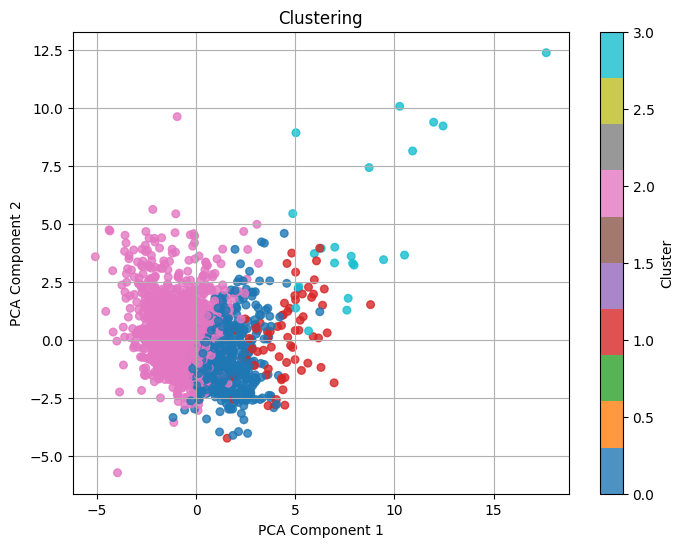

In [86]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

df = pd.read_csv(COUNTY_DATA_PATH).iloc[:,:17]
df.drop(columns=['Percent of adults who are not high school graduates, 2019-23', 'Percent of adults who are high school graduates (or equivalent), 2019-23', 'Percent of adults completing some college or associate degree, 2019-23', "Percent of adults with a bachelor's degree or higher, 2019-23"], inplace=True)
df.head()

scaler = StandardScaler()
df = scaler.fit_transform(df)

train, test = train_test_split(df, test_size=0.2, random_state=42)
model, embed, label = train_dec(train, n_clusters=4, latent_dim=8, num_layers=1, hidden_size=1024, epochs=2000, gamma=0.1, lr=1e-4)

sil_score = silhouette_score(train, label)
db_score = davies_bouldin_score(train, label)
ch_score = calinski_harabasz_score(train, label)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(train)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label, cmap='tab10', s=30, alpha=0.8)
plt.title("Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()

In [87]:
import numpy as np
np.unique(label)


array([0, 1, 2, 3])

In [85]:
model.eval()  # disable dropout, batchnorm (if used)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_test = torch.tensor(test, dtype=torch.float32).to(device)

with torch.no_grad():
    z_new, _ = model.encoder(x_test)
    q_new = model.soft_assign(z_new)         # soft cluster probabilities
    cluster_preds = torch.argmax(q_new, dim=1).cpu().numpy()

sil_score = silhouette_score(test, cluster_preds)
db_score = davies_bouldin_score(test, cluster_preds)
ch_score = calinski_harabasz_score(test, cluster_preds)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

Silhouette Score: 0.404
Davies-Bouldin Index: 1.326
Calinski-Harabasz Index: 29.968
